# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional: Análise de Imagens Médicas

> Atenção: este notebook foi desenhado para funcionar no **Google Collab**.


## 1. Introdução

Uma determinada fintech focada em consumidores finais pessoa física constataou um grande número de fraudes em transações bancárias.

O setor de fraudes apontou que existem clientes que se queixaram de não contratar serviços específicos, como o crédito pessoal, e após isso transferir para outras contas desconhecidas. 

Após análises pelas equipes de segurança, os protocolos de utilização da senha foram realizados em conformidade, ou seja, cada cliente autenticou com sua própria senha de maneira regular.

Em função disso, o banco precisa arcar com reembolsos e medidas de contenção para evitar processos judiciais, pois os clientes alegam terem sido invadidos por hackers ou algo parecido.

Uma das formas de solucionar ou minimizar este problema é com a utilização de outras formas de autenticação, sobretudo em operações críticas, como a obtenção de crédito pessoal.

Desta forma podemos implementar uma verificação de identidade com prova de vida (liveness), que utilize uma verificação e identificação facial. 

Caso o cliente não seja autenticado, ele será atendido por uma esteira dedicada e as evidências da não identificação serão encaminhadas para a área de IA para validação dos parâmetros e limiares para aperfeiçoamento do modelo.

Será necessário construir:

* Detector de faces
* Identificação de faces (podendo ser um comparador entre um rosto de documento e outra da prova de vida)
* Detecção de vivacidade (liveness) para evitar que um fraudador utilize uma foto estática.


>Formas alternativas de prover a identificação e prova de vivacidade, além destas que foram solicitadas poderão ser submetidas.


<p align="center">
    <img src="../imagens/liveness.gif">
</p>

Imagem retirada do [Grunge](https://www.grunge.com/192826/company-testing-robocop-facial-recognition-software-with-us-police/).

## 2. Instruções

Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas.

Iremos constuir uma forma de validar se uma determinada imagem foi ou não adulterada e se trata de uma produção fraudade.

Existem diversas formas de validar a vivacidade, e neste sentido conto com a criatividade de vocês dado que já dominam encontrar uma face numa imagem, aplicar marcos faciais e até mesmo construir uma rede neural convulacional.

A abordagem mais simples é pela construção de uma rede neural com imagens de fotos de rostos de outras fotos e fotos de rostos sem modificações. Tal classificador deverá classificar se dada imagem possui vivacidade ou não com uma pontuação de probabilidade.

Referências que abordam o tema para servir de inspiração:

1. [PyImageSearch](https://pyimagesearch.com/2019/03/11/liveness-detection-with-opencv/), Liveness detection with OpenCV;
2. [Kickertech](https://kickertech.com/face-liveness-detection-via-opencv-and-tensorflow/), Liveness detection via OpenCV and Tensorflow.
3. [Towards Data Science](https://towardsdatascience.com/real-time-face-liveness-detection-with-python-keras-and-opencv-c35dc70dafd3?gi=24f8e1b740f9), Real-time face liveness detection with Python, Keras and OpenCV.

Este projeto poderá ser feita por grupos de até 4 pessoas.
Caso este projeto seja substitutivo, deverá ser realizado por apenas uma pessoa.

| Nome dos Integrantes         | RM            | Turma |
| :--------------------------- | :------------- | :-----: |
| Alessandro Lazarotti         | RM 352517      | 5DTSR |
| Bruno Ernesto Cerentini      | RM 351018      | 5DTSR |
| Ciro Vargas de Souza Marques | RM 352843      | 5DTSR |
| Thiago Furnielis             | RM 350840      | 5DTSR |

## 3. Abordagem e organização da solução do problema (2 pontos)

Como o grupo pretende deteccar a prova de vivacidade de uma determinada imagem? Quais os passos e os building blocks deste processo?

**Resposta**: 

Optamos por utizar a técnica de *Transfering Learning*, com o apoio dos [modelos disponíveis](https://keras.io/api/applications/) pelo framework *Keras* do pacote *Tensorflow*.
Para o treinamento foram selecionados majoritariamente imagens disponíveis no dataset público [CelebA Spoof](https://github.com/ZhangYuanhan-AI/CelebA-Spoof), além de fotos do acervo pessoal dos alunos.

Proseguimos da seguinte forma:

1. Selecionamos e testamos diferentes modelos base do Keras para ver qual teria uma eficiencia razoável, sem necessariamente precisar de GPU para o treinamento.
2. Para o *Transfer Learning* congelamos as camadas convolucionais pré-treinadas, mantendo os pesos mas removendo a camada de treino.
3. Adicionamos no topo 4 novas camadas para um novo treino com nosso dataset. A primeira camada é a GlobalAveragePooling2D, que reduz a dimensionalidade dos mapas das features e ajuda a evitar overfitting. A segunda camada é densa, com 1024 neuronios e ativação ReLu; que é uma função não linear para aprender representações complexas. Na terceira camada foi introduzido um dropout para eviar overfiting durante o treinamento .A última camada adicionada é de saída, também é densa mas de classificação binária (por isso 1 neuronio e ativação sigmoid), para produzir uma "probabilidade" de foto com vivacidade.
4. O dataset foi dividido em 70% para treinamento e 30% para validação
5. Depois do treinamento, foi estabelecido métricas (acuracia, precisão, recall e f1) para confirmar a perfomance do modelo, além de gráficos de loss e acurácia para verificação do modelo.
6. Finalmente foi construída uma aplicação streamlit para simular o caso de uso proposto, com a finalidade de baseado no carregamento do modelo previamente aqui construído, obter a predição se determinada foto capturada por webcam ou atravéz de upload, possui vivacidade, por tanto é real, ou é possível fraude (baixa vivacidade).



## 4 Desenvolvimento da solução (5,5 pontos)

Detalhe o passo-a-passo do algoritmo de deteção de vivacidade.
Se optar pela construção e treinamento de um modelo de redes neurais convulucionais, apresente a arquitetura, prepare os dados de treinamento, realize o treinamento.

In [1]:
#instalar opencv-python e tensorflow caso nao tenha no ambiente
!pip3 install opencv-python tensorflow

In [2]:
#importacao de bibliotecas
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

2024-07-07 21:15:45.760048: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 21:15:45.760249: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-07 21:15:45.762861: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-07 21:15:45.792047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 21:15:46.265481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

### 4.1 Organização de dados para treinamento de modelo de liveness (2 pontos)

In [3]:
# Dividir o dataset em 70% treino e 30% validação com data augmentation
train_datagen = ImageDataGenerator(
    validation_split=0.3, 
    rescale=1./255,
    horizontal_flip=True,    
    preprocessing_function=preprocess_input
)

pasta_dataset = "../classes"

# Gerador de dados de treinamento
train_data = train_datagen.flow_from_directory(
    pasta_dataset,
    batch_size=32,
    class_mode='binary',
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=True,
    subset='training'
)

# Gerador de dados de validação
validation_data = train_datagen.flow_from_directory(
    pasta_dataset,
    batch_size=32,
    class_mode='binary',
    target_size=(224, 224),
    color_mode='rgb',
    shuffle=False,
    subset='validation'
)

Found 7020 images belonging to 2 classes.
Found 3007 images belonging to 2 classes.


### 4.2 Treinamento de modelo de liveness (1,5 pontos)

In [4]:
# Carregar o modelo ResNet50V2 pré-treinado, preservando os pesos
# mas excluindo as camadas de classificação
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

In [5]:
# Adicionar novas camadas densas para classificação binária
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout com 50% de desativação
predictions = Dense(1, activation='sigmoid')(x)

In [6]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [7]:
# Treinar o modelo
# Implementar early stopping para evitr overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Treinar o modelo com early stopping
hist = model.fit(train_data, epochs=20, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/20


/opt/apps/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 195s 871ms/step - binary_accuracy: 0.7240 - loss: 0.5459 - val_binary_accuracy: 0.7998 - val_loss: 0.4353
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 191s 866ms/step - binary_accuracy: 0.7889 - loss: 0.4496 - val_binary_accuracy: 0.7978 - val_loss: 0.4239
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 192s 868ms/step - binary_accuracy: 0.8065 - loss: 0.4192 - val_binary_accuracy: 0.8254 - val_loss: 0.3936
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 192s 870ms/step - binary_accuracy: 0.8030 - loss: 0.4138 - val_binary_accuracy: 0.8257 - val_loss: 0.3901
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 191s 866ms/step - binary_accuracy: 0.8143 - loss: 0.4026 - val_binary_accuracy: 0.8201 - val_loss: 0.3900
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 191s 863ms/step - binary_accuracy: 0.8303 - loss: 0.3774 - val_binary_accuracy: 0.8237 - val_loss: 0.3918
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 191s 864ms/step - binary_accuracy: 0.8334 - loss: 0.3623 - val_binary_accuracy: 0.8224 - val_lo

### 4.3 Métricas de desempenho do modelo (2 pontos)

In [8]:
preds = model.predict(validation_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 611ms/step


In [9]:
# salvar o modelo
model.save("../modelos/modelX.keras")

In [10]:
# Avaliar o modelo no conjunto de validação
loss, accuracy = model.evaluate(validation_data)
print(f"Loss: {loss}, Accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 603ms/step - binary_accuracy: 0.7904 - loss: 0.4635
Loss: 0.3852580487728119, Accuracy: 0.8260725140571594


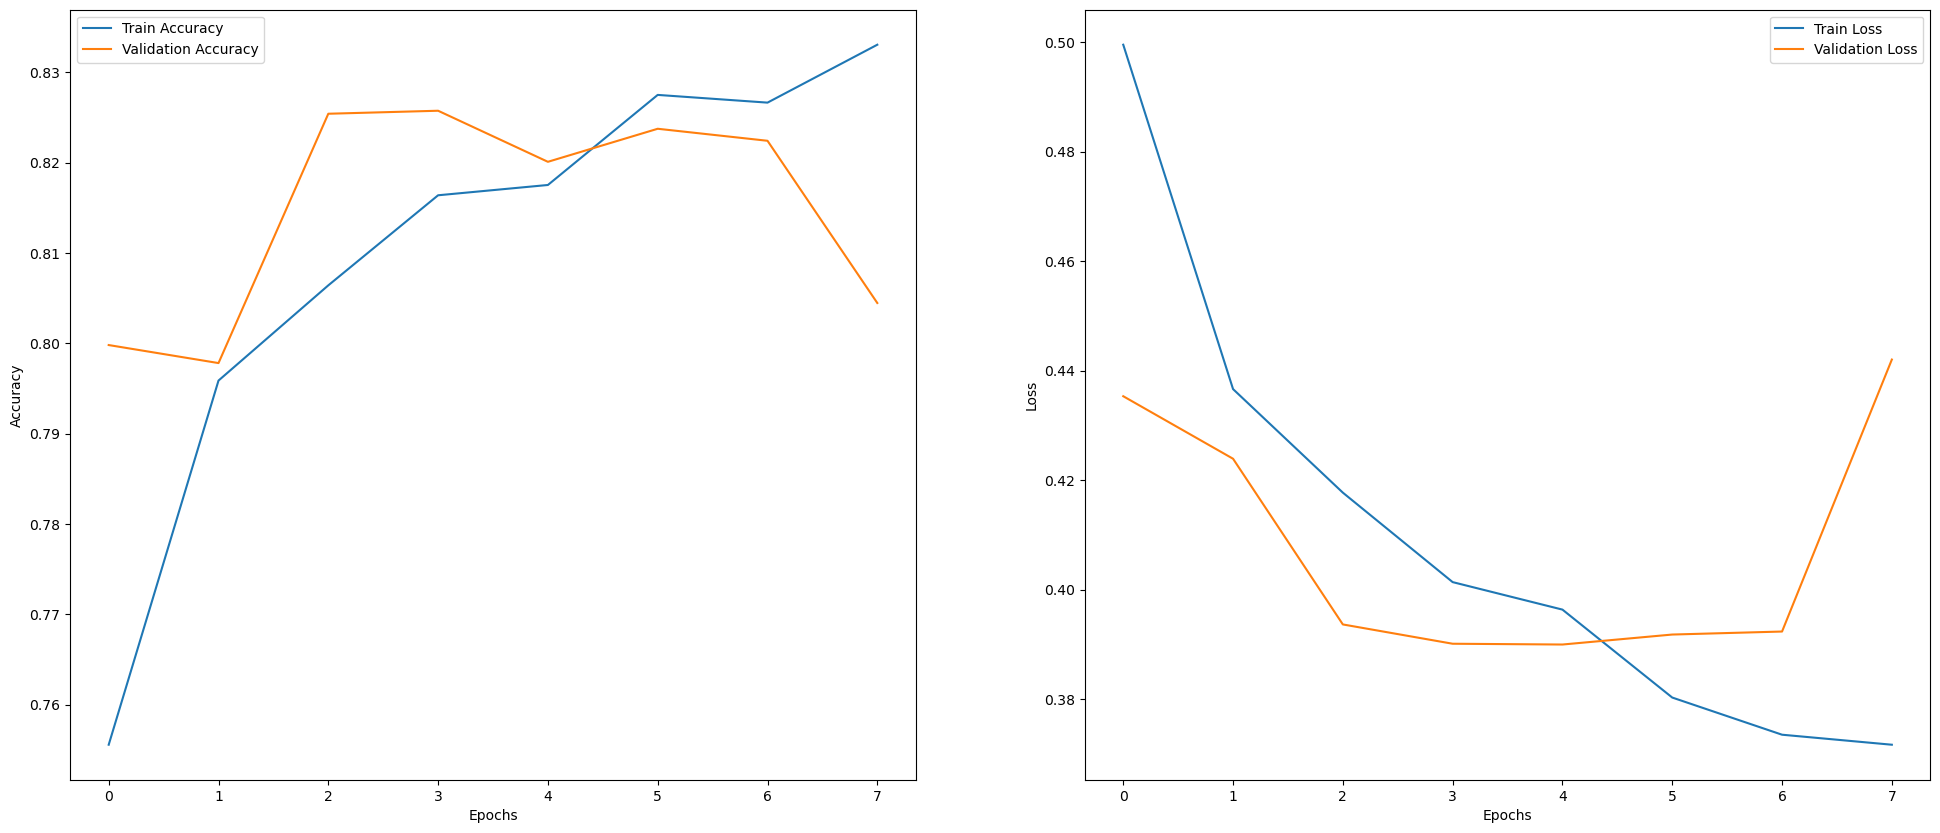

In [11]:
# Plotar as métricas de treinamento e validação
plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 1)
plt.plot(hist.history['binary_accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [12]:
# Relatório de classificação
predictions = (preds > 0.5).astype(int)
true_classes = validation_data.classes
class_labels = list(validation_data.class_indices.keys())

report = classification_report(true_classes, predictions, target_names=class_labels)

print(report)

              precision    recall  f1-score   support

        real       0.85      0.78      0.81      1501
       spoof       0.80      0.87      0.83      1506

    accuracy                           0.82      3007
   macro avg       0.82      0.82      0.82      3007
weighted avg       0.82      0.82      0.82      3007



As médias do modelo ficaram em torno de **~82%** para todos os atributos: *precisão*, *recall* e *acuracia*, o que é satisfatório para um modelo baseado em uma rede não muito densa e leve como a **ResNet50V2**. Este modelo apresentou um bom balanço entre performance no treino sem necessidade de GPU com resultados aceitáveis de acurácia e baixos falso negativos e positivos. Foram testados também neste projeto mas não foram adicionados neste notebook os modelos *VGG19*, *VGG16*, *InceptionResNetV2* e *DenseNet201*, mas que obtiveram resultados piores que *ResNet50V2* ou não performaram em treino o suficiente para ser concluído em tempo hábil sem GPU.
Os gráficos de acurácia e loss mostram que o *early stopping* funcionou bem na prevenção de *overfitting*.

## 5 Teste Fim-a-Fim

Simule a operação fim-a-fim, com uma imagem de entrada forjada (foto de foto de um rosto) e outra com uma imagem de rosto, exibindo o resultado da classificação e a pontuação de cada classe.

In [13]:
#IMPLEMENTAR

>Com a implementação da solução na forma de uma aplicação do [Streamlit](https://www.streamlit.io/) (veja a pata streamlit-app e use o template) vale 1 ponto adicional.

**Pergunta**: Se utilizou o Streamlit, compartilhe a URL do aplicativo publicado:

**Resposta**:

## 6 Conclusões (2,5 pontos)

**Pergunta**: Dado todo o estudo e pesquisa, quais foram as conclusões sobre a solução, o que funcionou, o que não funcionou e quais os detalhes que observariam numa nova versão e melhorias do processo?

**Resposta**:
Embora as métricas em torno de 82% sejam aceitáveis, na prática se a foto da webcam apresentar muito ruído ou o ambiente não for claro o suficiente, o modelo tende a classificar como fraude (*spoof*). Isso se deve primariamente porque os dados de teste se basearam em um dataset extenso onde as fotos reais são fotos de nitidez com pouca distorção, enquanto spoof são fotos com distorção de impressão ou de angulo, o que pode confudir o modelo em situação de camêra real mas com pouca nitidez.

Outro problema é se a "*foto fraude*" a ser apresentada for de boa nitidez. Isso pode fezer com que o modelo atual o classifique como real, já que nitidez e textura independente do contexto do background, parece ser de grande relevancia para este modelo.

Em uma situação real, formas de evitar estes problemas, incluem:
1. Usar um dataset com muito mais dados, usando imagens de captura real de webcam de baixa resolução como classificação de foto real.
2. Usar com o auxilio de GPU um modelo de rede mais densa que a *ResNet50V2*, que consiga obter mais detalhes das fotos para evitar a classificação de "real" de fotos *spoof* com alta nitidez.
3. Usar tecnicas mais avançadas, como verificação de piscadas ou pequenos movimentos, como parte de comprovação de liveness.
4. Utilizar mapeamento 3D com uso de cameras e iluminacao especificas para comprovação de vivacidade.